In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Создание искуственной линейно неразделимой задачи

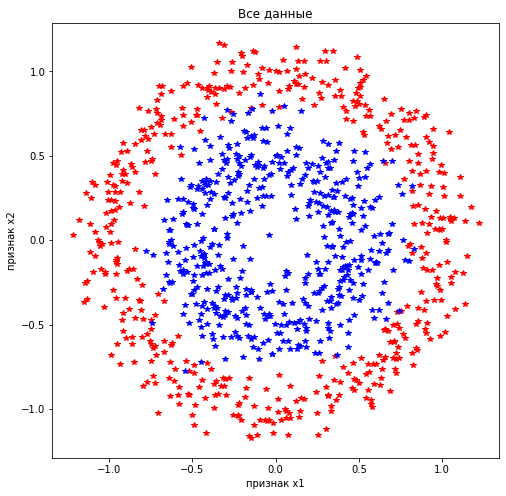

In [ ]:
num = 500

red = np.column_stack([np.sin(np.linspace(0, 2*np.pi, num))+np.random.normal(scale=0.10, size=(num)),
                       np.cos(np.linspace(0, 2*np.pi, num))+np.random.normal(scale=0.10, size=(num))])
blue = np.column_stack([np.sin(np.linspace(0, 2*np.pi, num))/2+np.random.normal(scale=0.15, size=(num)),
                       np.cos(np.linspace(0, 2*np.pi, num))/2+np.random.normal(scale=0.15, size=(num))])

plt.figure(figsize=(8, 8))
plt.title('Все данные')
plt.xlabel('признак x1')
plt.ylabel('признак x2')
plt.plot(red[:,0], red[:,1], 'r*')
plt.plot(blue[:,0], blue[:,1], 'b*')

In [ ]:
df = pd.DataFrame({'x1':np.concatenate([red, blue])[:,0], 'x2':np.concatenate([red, blue])[:,1], 'target':[0]*num + [1]*num})
df = df.sample(frac=1).reset_index(drop=True)
df

,x1,x2,target
0,1.051579,-0.255009,0
1,-0.669855,-0.358932,0
2,0.560307,-0.780346,0
3,0.018854,0.454114,1
4,-0.328024,-0.862266,0
...,...,...,...
995,0.574894,-0.968475,0
996,-0.954440,-0.615512,0
997,0.100669,-0.374086,1
998,-0.474664,-0.154709,1


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df[['x1', 'x2']], df['target'], test_size=0.2, stratify=df['target'])

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 2), (200, 2), (800,), (200,))

In [ ]:
print('Распределение ответов на train: \n', y_train.value_counts())
print('\nРаспределение ответов на test: \n', y_test.value_counts())

Распределение ответов на train: 
 0    400
1    400
Name: target, dtype: int64

Распределение ответов на test: 
 0    100
1    100
Name: target, dtype: int64


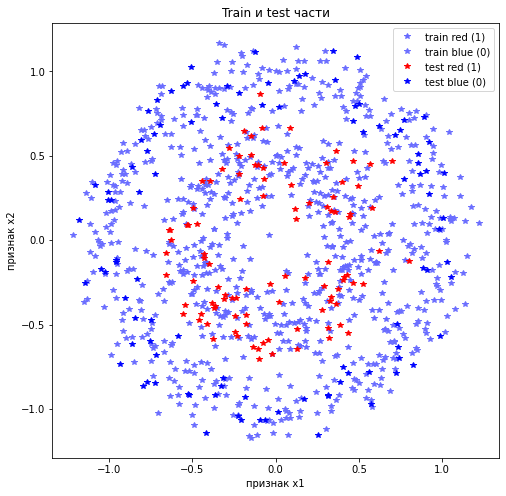

In [ ]:
plt.figure(figsize=(8, 8))
plt.title('Train и test части')
plt.xlabel('признак x1')
plt.ylabel('признак x2')
plt.plot(X_train[y_train == 1]['x1'], X_train[y_train == 1]['x2'], '*', color='#6669ff', label='train red (1)')
plt.plot(X_train[y_train == 0]['x1'], X_train[y_train == 0]['x2'], '*', color='#6b6eff', label='train blue (0)')
plt.plot(X_test[y_test == 1]['x1'], X_test[y_test == 1]['x2'], '*', color='#ff0000', label='test red (1)')
plt.plot(X_test[y_test == 0]['x1'], X_test[y_test == 0]['x2'], '*', color='#0004ff', label='test blue (0)')
plt.legend()

# Реализация через torch

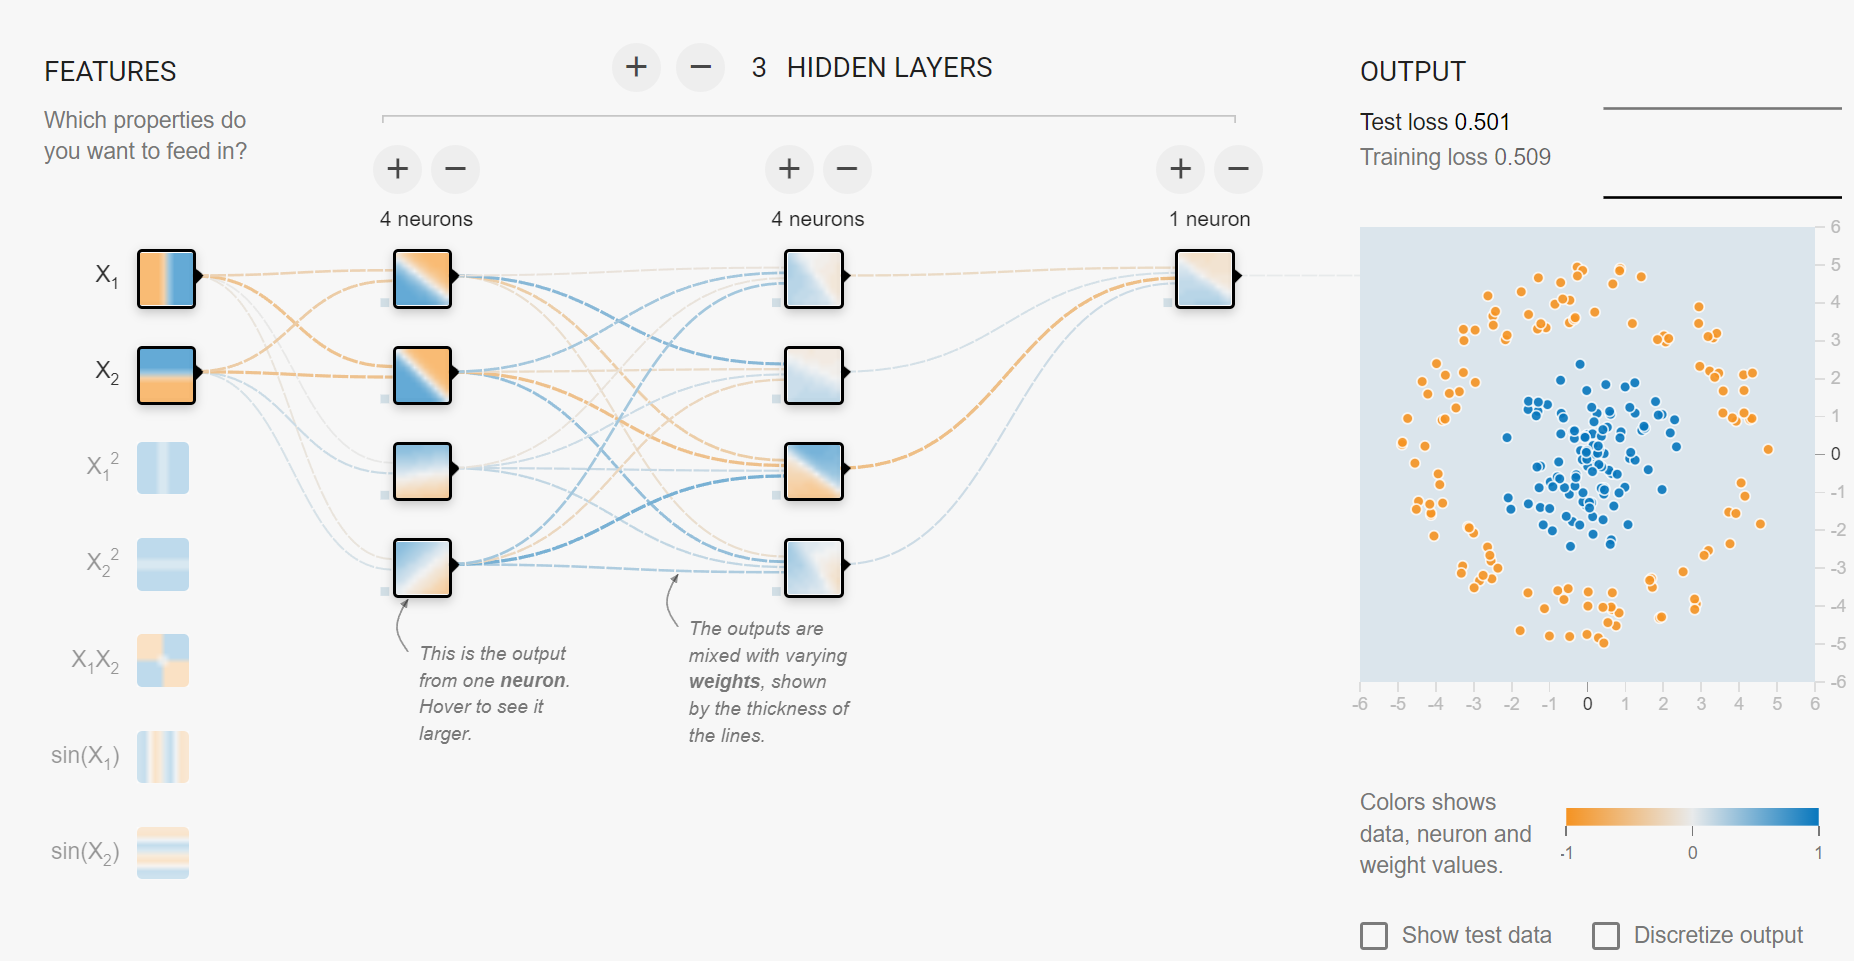

In [ ]:
import torch
import torch.nn as nn

X_train_torch = torch.tensor(X_train.values)
y_train_torch = torch.tensor(y_train.values)
X_test_torch = torch.tensor(X_test.values)
y_test_torch = torch.tensor(y_test.values)

model = torch.nn.Sequential(*[
    nn.Linear(2, 4),
    nn.ReLU(),
    nn.Linear(4, 4),
    nn.ReLU(),
    nn.Linear(4, 2),
])

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.03)

Один цикл запуска выглядит так:

In [ ]:
# for epoch in range(2):
for X, y in zip(X_train_torch, y_train_torch):

    print(f'data: {X}, target: {y}')
    preds = model(X.float())
    print('Model preds:', preds)
    print(f'Transforming {y} to one-hot {torch.eye(2)[y]}')
    loss = loss_fn(preds, torch.eye(2)[y])
    print('model loss value:', loss)
    break

data: tensor([0.8996, 0.1860], dtype=torch.float64), target: 0
Model preds: tensor([-0.1694,  0.4862], grad_fn=<AddBackward0>)
Transforming 0 to one-hot tensor([1., 0.])
model loss value: tensor(0.8735, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [ ]:
loss_history = []
for epoch in range(40):
    for X, y in zip(X_train_torch, y_train_torch):
        preds = model(X.float())
        optimizer.zero_grad()
        loss = loss_fn(preds, torch.eye(2)[y])
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())

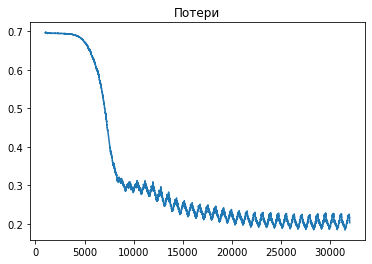

In [ ]:
plt.title('Потери')
pd.Series(loss_history).rolling(num*2).mean().plot()

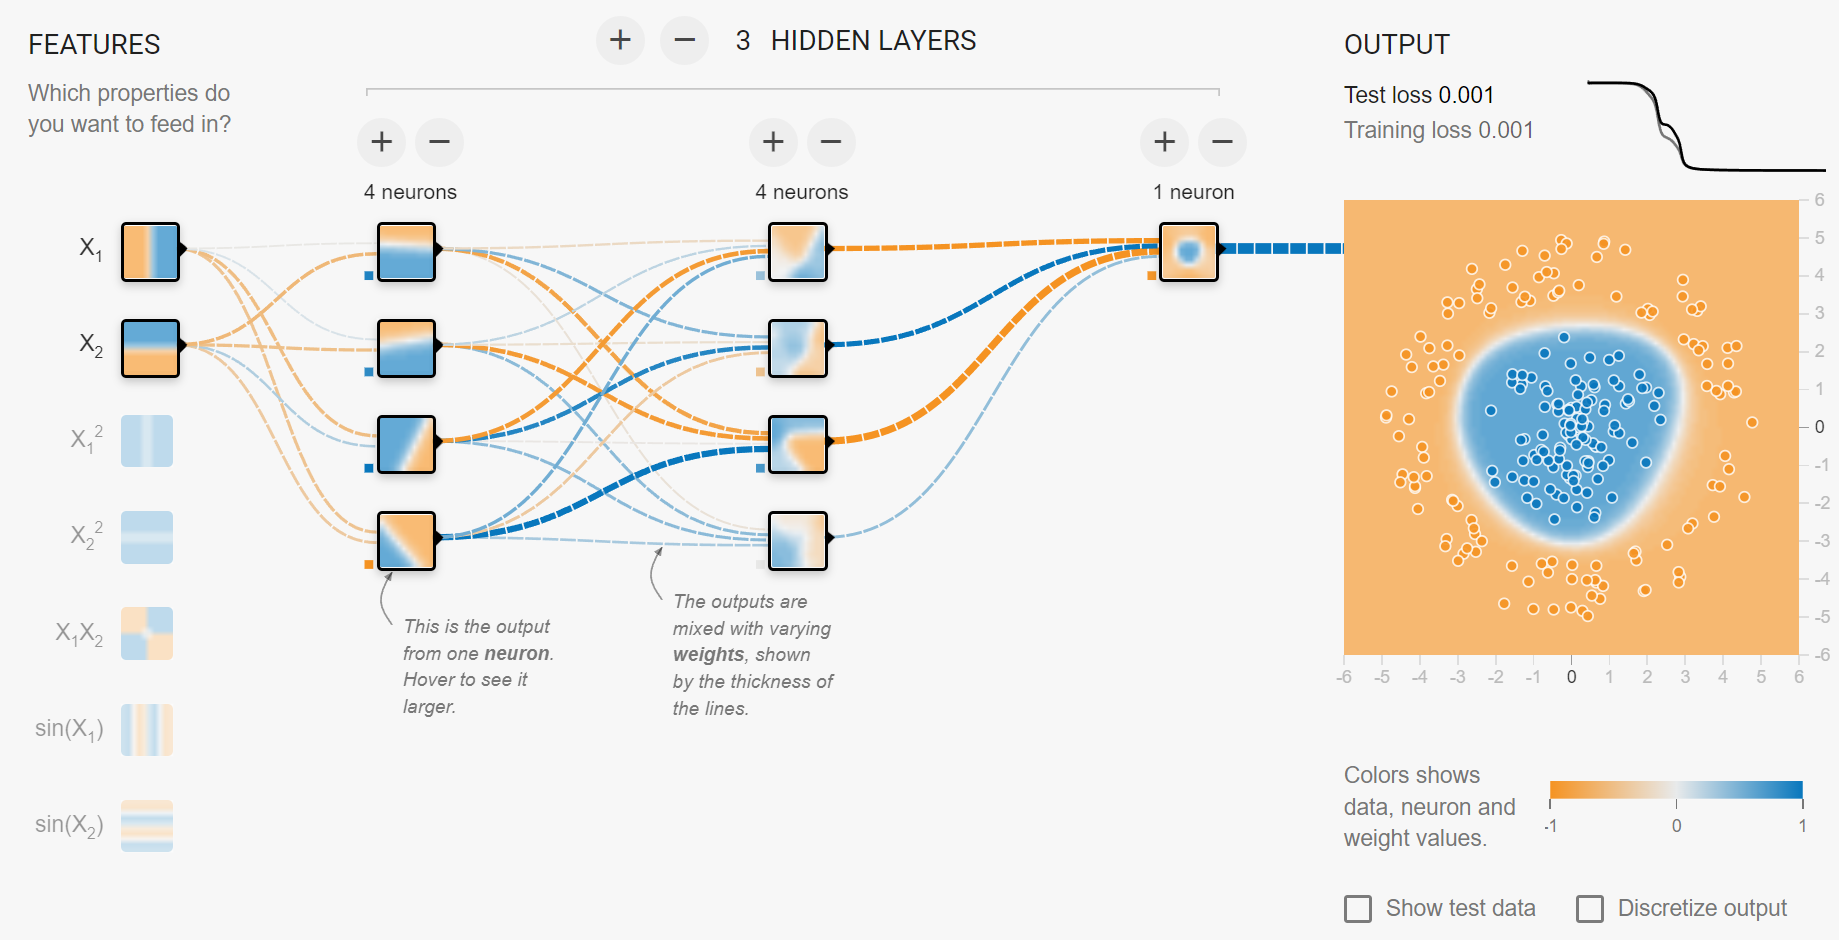

In [ ]:
test_preds = model(X_test_torch.float())
test_preds = torch.argmax(test_preds, axis=1)

In [ ]:
test_preds.shape, y_test_torch.shape

(torch.Size([200]), torch.Size([200]))

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, test_preds.numpy()))

              precision    recall  f1-score   support

           0       0.91      0.94      0.93       100
           1       0.94      0.91      0.92       100

    accuracy                           0.93       200
   macro avg       0.93      0.93      0.92       200
weighted avg       0.93      0.93      0.92       200



## Реализация с нуля

# Активации

## Сигмоидальная

In [ ]:
'''
Класс сигмоидальной активации
Реализует прямой и обратный проход
Подробнее https://youtu.be/Lakz2MoHy6o?t=1791
'''
class Sigmoid():
    # прямой проход по формуле сигмоиды
    # сохраняем вход для расчета вектора градиента по нему
    def forward(self, x):
        self.input = x
        return 1 / (1 + np.exp(-x))

    '''
    output gradient - np.array вектор градиента распространенный от слов перед ним
    learning_rate - float скорость обучения
    '''
    def backward(self, output_gradient, learning_rate):
        s = self.forward(self.input)
        # вывод производной сигмоиды https://hausetutorials.netlify.app/posts/2019-12-01-neural-networks-deriving-the-sigmoid-derivative/#:~:text=The%20derivative%20of%20the%20sigmoid%20function%20%CF%83(x)%20is%20the,1%E2%88%92%CF%83(x).
        sigmoid_grad = s * (1 - s)
        # градиент от поэлементной функциии (любая активация) - диагональная
        # можем просто засунуть выходной градиент в производную от заданной функции активации
        # (почему это так см. https://youtu.be/pauPCy_s0Ok?t=1248)
        return np.multiply(output_gradient, sigmoid_grad)

## Функция активации гиперболический тангенс

In [ ]:
'''
Класс активации гиперболического тангенса
Реализует прямой и обратный проход
подробнее см. https://youtu.be/pauPCy_s0Ok?t=1350
'''
class Tanh():
    # прямой проход по формуле гиперболического тангенса
    # сохраняем вход для расчета вектора градиента по нему
    def forward(self, x):
        self.input = x
        return np.tanh(x)
    '''
    output gradient - np.array вектор градиента распространенный от слов перед ним
    learning_rate - float скорость обучения
    '''
    def backward(self, output_gradient, learning_rate):
        # вывод производной гиперболического тангенса
        # https://stackoverflow.com/questions/62634073/why-gradient-of-tanh-in-tensorflow-is-grad-dy-1-yy
        tanh_grad = 1 - np.tanh(self.input) ** 2
        # почему так см. примечания сигмоды
        return np.multiply(output_gradient, tanh_grad)

## Функция активации softmax

In [ ]:
class Softmax():
    def forward(self, input):
        tmp = np.exp(input)
        self.output = tmp / np.sum(tmp)
        return self.output
    
    def backward(self, output_gradient, learning_rate):
        n = np.size(self.output)
        return np.dot((np.identity(n) - self.output.T) * self.output, output_gradient)

# Бинарная кросс-энтропия

In [ ]:
'''
Формула бинарной кросс энтропии справедлива если
целевая переменная 1 или 0
Фукнции прямого и обратного прохода вынесены 
в отдельные модули для более ясного выделения градиента
и его отправки в backward методы прочих активаций и слоев
Подробнее https://youtu.be/Lakz2MoHy6o?t=1674
'''
def binary_cross_entropy(y_true, y_pred):
    return np.mean(-y_true * np.log(y_pred) - (1 - y_true) * np.log(1 - y_pred))
# градиент по бинарной кросс-энтропии, см https://youtu.be/Lakz2MoHy6o?t=1674
def binary_cross_entropy_prime(y_true, y_pred):
    return ((1 - y_true) / (1 - y_pred) - y_true / y_pred) / np.size(y_true)

# Классы слоев

## Полносвязный слой

In [ ]:
'''
Класс полносвязного слоя
Реализует прямой и обратный проход
Подробнее https://youtu.be/Lakz2MoHy6o
'''
class Dense():
    '''
    Конструктор класса инициализирует веса слоя
    input_shape: typle - форма входного тензора
    output_shape: typle - форма выходного тензора
    '''
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(output_size, input_size)
        self.bias = np.random.randn(output_size, 1)
    '''
    input: входные данные (вектор)
    Прямой проход - действие матрицы весов на входные данные y = WX + b
    '''
    def forward(self, input):
        self.input = input
        return np.dot(self.weights, self.input) + self.bias
    '''
    output gradient - np.array вектор градиента распространенный от слов перед ним
    learning_rate - float скорость обучения
    Реализует обратный проход по полносвязному слою, находя производные 
    по входам (чтобы распространить сигнал потерь в предшествующие слои), весам слоя и смещениям
    Подробнее https://youtu.be/pauPCy_s0Ok?t=1102
    '''
    def backward(self, output_gradient, learning_rate):
        # производная по весам слоя - скаляреное произведелние между гражиентов слоя перед
        # и транспонированным входом (см. https://youtu.be/pauPCy_s0Ok?t=683)
        weights_gradient = np.dot(output_gradient, self.input.T)
        # градиент по входам - скалярное между транспонированными весами и градиентов слоя перед
        # необходим, чтобы рассчитать градиент более ранних слоев
        # (см. https://youtu.be/pauPCy_s0Ok?t=988)
        input_gradient = np.dot(self.weights.T, output_gradient)
        # шаг град спуска
        self.weights -= learning_rate * weights_gradient
        # градиент по смещениям = градиента слоя перед (см. https://youtu.be/pauPCy_s0Ok?t=899)
        # делаем шаг по минус градиенту с заданной скоростью
        self.bias -= learning_rate * output_gradient
        # возвращаем градиент по входам для распространения сигнала градиента в предшествующие слои
        return input_gradient

# Функция обучения

In [ ]:

def predict(network, input):
    output = input
    for layer in network:
        output = layer.forward(output)
    return output

'''
Функция тренировки
network - список из самописных слоев с прямым (forward) и обратным проходом
loss - функция прямого (forward) прохода функции потерь (принимает на вектора ответов и прогнозов)
loss_prime - функция обратного  (backward) прохода функции потерь (принимает на вектора ответов и прогнозов)
x_train - входные данные (изображения)
у_train - ответы (one-hot вектора для классификации)
epoch - количество эпох (полного показывания всех точек данных)
learning_rate - скорость обучения
verbose - отображать ли loss при обучении
'''
def train(network, loss, loss_prime, x_train, y_train, epochs = 1000, learning_rate = 0.01, verbose = True):
    # итерируемся по всем эпохам
    for e in range(epochs):
        # считаем ошибку
        error = 0
        # распаковываем картинки и их one-hot ответы
        for x, y in zip(x_train, y_train):
            # прямой проход
            output = predict(network, x)
            # значения функции потерь
            error += loss(y, output)
            # градиент функции потерь
            grad = loss_prime(y, output)
            # идет от выходов к входам
            for layer in reversed(network):
                # вызывая метод backward каждого элемента, подавая градиент по входам с прошлых шагов
                # на первом шаге это градиент функции потерь
                grad = layer.backward(grad, learning_rate)
        # усредняем ошибку для всей эпохи
        error /= len(x_train)
        # отображаем, если включено
        if verbose:
            print(f"{e + 1}/{epochs}, error={error}")

# Выпрямление

Необходимо для превращения картинки (трехмерный тензор из 1 канала, ширины 28 высоты 28) в вектор столбец.

In [ ]:
'''
Модуль "выпрямления"
подробнее см. https://youtu.be/Lakz2MoHy6o?t=1648
Подробнее формы входного и выходного тензора выпрямляет вход при прямом проходе и градиент при обратном проходе
'''
class Reshape():
    '''
    input_shape: форма входного тензора
    output_shape: форма выходного тензора
    '''
    def __init__(self, input_shape, output_shape):
        self.input_shape = input_shape
        self.output_shape = output_shape
    '''
    input - np.array входной вектор данных
    преобразует входные данные из (формы входа) в (форму выхода)
    '''
    def forward(self, input):
        return np.reshape(input, self.output_shape)

    # преобразует градиент из в размер (формы выхода)
    def backward(self, output_gradient, learning_rate):
        return np.reshape(output_gradient, self.input_shape)

# Обучение на синтетических данных

In [ ]:
X_train.shape, y_train.shape

((800, 2), (800,))

In [ ]:
from keras.utils import np_utils

y_test = np_utils.to_categorical(y_test.values)
# создаем one-hot encoding ответов для соответсвия размера выходов вектора бинарной CE
# 0 -> [1, 0], 1 -> [0, 1]
y_test = y_test.reshape(len(y_test), 2, 1)
y_test.shape

(200, 2, 1)

In [ ]:
y_test[:5]

array([[[1.],
        [0.]],

       [[0.],
        [1.]],

       [[1.],
        [0.]],

       [[1.],
        [0.]],

       [[0.],
        [1.]]], dtype=float32)

In [ ]:
y_train = np_utils.to_categorical(y_train.values)
# создаем one-hot encoding ответов для соответсвия размера выходов вектора бинарной CE
# 0 -> [1, 0], 1 -> [0, 1]
y_train = y_train.reshape(len(y_train), 2, 1)
y_train.shape

(800, 2, 1)

In [ ]:
X_train.shape, y_test.shape

((800, 2), (200, 2, 1))

In [ ]:
# инициализируем двуслойную сверточную нейросеть
network = [
    # Reshape((1, 28, 28), (1 * 28 * 28, 1)),
    Reshape((2,), (2, 1)),
    Dense(2, 150),
    Sigmoid(),
    Dense(150, 12),
    Sigmoid(),
    Dense(12, 2),
    Sigmoid(),
]

# вызываем функцию обучени
train(
    network,
    binary_cross_entropy,
    binary_cross_entropy_prime,
    X_train.values, # метод .values конвертирует в нампай массив т.к. это пандас датафрейм
    y_train,
    epochs=25,
    learning_rate=0.005
)

1/25, error=0.730748955631678
2/25, error=0.6839952001869886
3/25, error=0.662626458600228
4/25, error=0.6486935238976302
5/25, error=0.6371538883611149
6/25, error=0.626163097076971
7/25, error=0.6153270998824703
8/25, error=0.6050062442008215
9/25, error=0.5950352883696226
10/25, error=0.5850367986911813
11/25, error=0.5748453159680124
12/25, error=0.5644297743778293
13/25, error=0.5538027753700497
14/25, error=0.542992353489504
15/25, error=0.5320348848626376
16/25, error=0.5209722562025938
17/25, error=0.509849714789283
18/25, error=0.4987138524139722
19/25, error=0.4876107840049471
20/25, error=0.4765846742320336
21/25, error=0.4656767076238498
22/25, error=0.4549244940120841
23/25, error=0.4443618039569529
24/25, error=0.43401847223323275
25/25, error=0.4239203104401845


In [ ]:
preds = [predict(network, X_test.values[i]) for i in range(len(X_test))]
np.array(preds).shape

(200, 2, 1)

In [ ]:
preds = np.argmax(np.array(preds), axis=1)
preds.shape

(200, 1)

In [ ]:
# необходимо перевести отметы в векторный onehot вид
y_test.shape

(200, 2, 1)

In [ ]:
real = np.argmax(y_test, axis=1)
real.shape

(200, 1)

In [ ]:
print(classification_report(real, preds))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       100
           1       0.99      0.96      0.97       100

    accuracy                           0.97       200
   macro avg       0.98      0.97      0.97       200
weighted avg       0.98      0.97      0.97       200



# Фукнция подготовки данных MNIST

In [ ]:
from keras.datasets import mnist
from keras.utils import np_utils

'''
Ограничиват данные только двумя классами MNIST, создавая подвыборку
'''
def preprocess_data(x, y, limit):
    # находит индексы класса 0 в выборке, обрезает под заданный размер подвыборки
    zero_index = np.where(y == 0)[0][:limit]
    # находит индексы класса 1 в выборке, обрезает под заданный размер подвыборки
    one_index = np.where(y == 1)[0][:limit]
    # собирает их вместе 
    all_indices = np.hstack((zero_index, one_index))
    # перемешивает
    all_indices = np.random.permutation(all_indices)
    # выбирает их из всего набора
    x, y = x[all_indices], y[all_indices]
    # переформатирует под размер изображения
    x = x.reshape(len(x), 1, 28, 28)
    # нормализует путем /255 т.к. яркости - int от 0 до 255
    x = x.astype("float32") / 255
    # создает one-hot encoding ответов для соответсвия размера выходов вектора бинарной CE
    # 0 -> [1, 0], 1 -> [0, 1]
    y = np_utils.to_categorical(y)
    # dense ожидает не 0, 1, 2 а one-hot encoding ответов
    y = y.reshape(len(y), 2, 1)
    return x, y

# загржает MNIST из keras
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, y_train = preprocess_data(x_train, y_train, 2000)
x_test, y_test = preprocess_data(x_test, y_test, 200)

In [ ]:
# форма train
x_train.shape, y_train.shape

((4000, 1, 28, 28), (4000, 2, 1))

In [ ]:
# форма test
x_test.shape, y_test.shape

((400, 1, 28, 28), (400, 2, 1))

# Обучение

In [ ]:
# инициализируем двуслойную сверточную нейросеть
network = [
    Reshape((1, 28, 28), (1 * 28 * 28, 1)),
    Dense(1 * 28 * 28, 256),
    Sigmoid(),
    Dense(256, 128),
    Sigmoid(),
    Dense(128, 2),
    Sigmoid(),
]

# вызываем функцию обучени
train(
    network,
    binary_cross_entropy,
    binary_cross_entropy_prime,
    x_train,
    y_train,
    epochs=2,
    learning_rate=0.003
)

1/2, error=0.3222026203044939
2/2, error=0.06409839258631361


# Inference

In [ ]:
preds = [predict(network, x_test[i]) for i in range(len(x_test))]
np.array(preds).shape

(400, 2, 1)

In [ ]:
preds = np.argmax(np.array(preds), axis=1)
preds.shape

(400, 1)

In [ ]:
real = np.argmax(y_test, axis=1)
real.shape

(400, 1)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(real, preds))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       200
           1       0.99      0.99      0.99       200

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400



# Визуализация результатов

In [ ]:
x_test[:2]

array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]]], dtype=float32)

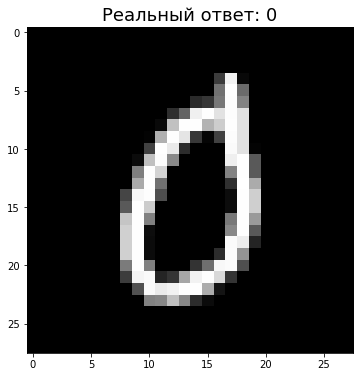

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.title(f'Реальный ответ: {np.argmax(y_test[0])}', fontdict={'fontsize':18})
plt.imshow(x_test[0].reshape((28, 28)), cmap='gray')

In [ ]:
y_test[:2]

array([[[1.],
        [0.]],

       [[0.],
        [1.]]], dtype=float32)

In [ ]:
x_test[:2].shape

(2, 1, 28, 28)

In [ ]:
preds = [predict(network, x_test[i]) for i in range(len(x_test))]
np.array(preds).shape

(400, 2, 1)

In [ ]:
preds = np.argmax(np.array(preds), axis=1)
preds.shape

(400, 1)

In [ ]:
real = np.argmax(y_test, axis=1)
real.shape

(400, 1)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(real, preds))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       200
           1       0.99      0.99      0.99       200

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400



Рассмотрим примеры, на которых нейронка не справилась:

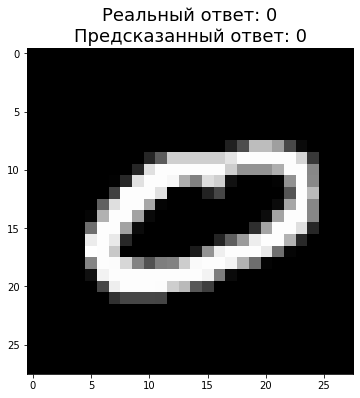

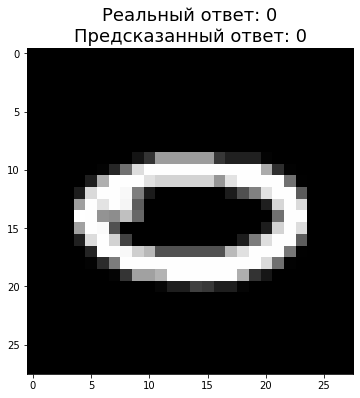

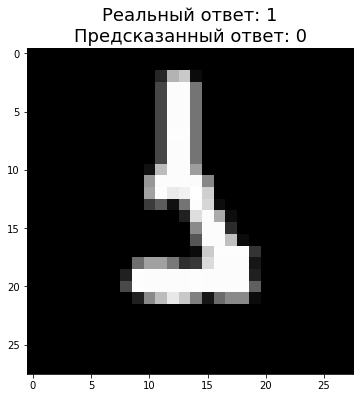

In [ ]:
import matplotlib.pyplot as plt

# индесы картинок которые не совпадают с ответом
for wrong_id in np.where(real != preds)[0]:
    # визуализируем нужные картинки по индексу
    plt.figure(figsize=(6, 6))
    plt.title(f'Реальный ответ: {np.argmax(y_test[wrong_id])}\nПредсказанный ответ: {np.argmax(real[wrong_id])}', fontdict={'fontsize':18})
    plt.imshow(x_test[wrong_id].reshape((28, 28)), cmap='gray')